###  阶段一：确认机械臂和摄像头是否正确连接

In [ ]:
# ✅ 设置项目路径，确保后续模块导入正常
import os, sys
import cv2

project_root = "/home/wjw/lerobot"
sys.path.insert(0, project_root)
os.chdir(project_root)

print("✅ 当前项目路径:", os.getcwd())



In [ ]:
# ✅ 检查机械臂串口设备
print("🔌 当前系统串口设备：")
!ls /dev/ttyACM*

print("\n📍 查看串口设备序列号（推荐用于绑定）：")
!ls -l /dev/serial/by-id/

input("👉 请确认这些端口是否与 koch_robot_config.py 中的配置一致后，再按 Enter 继续")

In [ ]:
# ✅ 检测 Type-C 接口是否成功识别为串口设备
import time

def list_serial_ports():
    return set(p for p in os.listdir('/dev') if p.startswith('ttyACM') or p.startswith('ttyUSB'))

print("🔌 请先 **拔掉 Type-C 机械臂**，然后按 Enter...")
input()
before = list_serial_ports()

print("🔌 现在插上设备，等待 5 秒...")
time.sleep(5)
after = list_serial_ports()

new_ports = after - before
if new_ports:
    print(f"🎯 新识别串口设备: {', '.join('/dev/' + p for p in new_ports)}")
else:
    print("⚠️ 未检测到新串口设备，请检查接口或线缆")


In [ ]:
# ✅ 检查摄像头设备是否正确连接
print("🎥 当前摄像头设备列表：")
!ls /dev/video*

print("\n📷 查看摄像头设备详细信息（确认 E22S 与 E12）：")
!v4l2-ctl --list-devices

In [ ]:
# # ✅ （可选）删除旧标定缓存文件，慎用
# import shutil

# calib_path = "/home/wjw/lerobot/.cache/calibration/koch/"
# if os.path.exists(calib_path):
#     shutil.rmtree(calib_path)
#     print("⚠️ 旧标定缓存已删除")
# else:
#     print("✅ 无旧缓存，无需清除")

# print("✅ Step 3：已执行缓存检查与清除")  

In [ ]:
# # ✅ 实例化 Koch 配置，并检查摄像头设置是否加载成功
#一定要先查看就

from lerobot.common.robot_devices.robots.configs import KochRobotConfig
from lerobot.common.robot_devices.robots.manipulator import ManipulatorRobot
from lerobot.common.robot_devices.cameras.configs import OpenCVCameraConfig

robot_cfg = KochRobotConfig()

# ✅ 使用当前 camera_index（不再使用 device 路径）
robot_cfg.cameras = {
    "e22s_side": OpenCVCameraConfig(
        camera_index=4,  # /dev/video3 = E22S 侧视
        fps=30,
        width=640,
        height=480,
    ),
    "e12_top": OpenCVCameraConfig(
        camera_index=2,  # /dev/video4 = E12 俯视
        fps=30,
        width=640,
        height=480,
    ),
}

robot = ManipulatorRobot(robot_cfg)
print("🤖 正在连接机器人...（首次运行将自动进入标定）")
robot.connect()

print("✅ 标定完成，已加载摄像头配置:")
for name, cam in robot_cfg.cameras.items():
    print(f" - {name}: /dev/video{cam.camera_index}")



In [ ]:
# ✅ 查看当前是否存在机械臂标定文件
!ls -l /home/wjw/lerobot/.cache/calibration/koch/

In [ ]:
# 读取主臂的状态
leader_status = robot.leader_arms["main"].read("Hardware_Error_Status")
leader_torque = robot.leader_arms["main"].read("Torque_Enable")
leader_position = robot.leader_arms["main"].read("Present_Position")

# 读取从臂的状态
follower_status = robot.follower_arms["main"].read("Hardware_Error_Status")
follower_torque = robot.follower_arms["main"].read("Torque_Enable")
follower_position = robot.follower_arms["main"].read("Present_Position")

# 打印结果
print("✅ 主臂硬件错误状态:", leader_status)
print("✅ 主臂扭矩状态:", leader_torque)
print("✅ 主臂当前关节位置:", leader_position)
print("✅ 从臂硬件错误状态:", follower_status)
print("✅ 从臂扭矩状态:", follower_torque)
print("✅ 从臂当前关节位置:", follower_position)

from lerobot.common.robot_devices.motors.dynamixel import TorqueMode

In [10]:
# # Cell 6: 测试主从同步遥控
# import time
# import tqdm

# print("开始主从同步测试，时长 15 秒，频率 30Hz...")
# seconds = 15
# frequency = 30
# interval = 1 / frequency

# for _ in tqdm.tqdm(range(seconds * frequency)):
#     leader_pos = robot.leader_arms["main"].read("Present_Position")
#     robot.follower_arms["main"].write("Goal_Position", leader_pos)
#     time.sleep(interval)

# print("✅ 主从臂同步测试完成！")


# Cell 6: 测试主从同步遥控，仅仅只是同步的测试，未涉及机械臂和摄像头的同步工作
import time
import tqdm

print("开始主从同步测试，时长 30 秒，频率 200Hz...")
seconds = 30
frequency = 200
interval = 1 / frequency

for _ in tqdm.tqdm(range(seconds * frequency)):
    leader_pos = robot.leader_arms["main"].read("Present_Position")
    robot.follower_arms["main"].write("Goal_Position", leader_pos)
    time.sleep(interval)

print("✅ 主从臂同步测试完成！")

开始主从同步测试，时长 30 秒，频率 200Hz...


 21%|████████▏                              | 1264/6000 [00:13<00:48, 96.73it/s]


KeyboardInterrupt: 

In [ ]:
import os
import subprocess

def check_camera_usage(video_devices=["/dev/video0", "/dev/video2"]):
    print("🔍 正在检查摄像头占用情况...\n")
    for dev in video_devices:
        try:
            result = subprocess.run(["lsof", dev], capture_output=True, text=True)
            if result.stdout:
                print(f"⚠️ {dev} 正被以下进程占用：\n{result.stdout}")
            else:
                print(f"✅ {dev} 当前未被占用，可安全访问。")
        except Exception as e:
            print(f"❌ 无法检查 {dev}：{e}")

check_camera_usage()

print("💡 如遇摄像头无法打开，请执行：")
print("1️⃣ 终端中运行 `lsof /dev/video0` 等命令查看占用进程")
print("2️⃣ 使用 `kill -9 <PID>` 释放占用,即 sudo kill -9 <PID>")
print("3️⃣ 重启 Jupyter Kernel 并重新连接摄像头")



In [7]:
# (lerobot) wjw@wjw-ASUS-TUF-Gaming-F15-FX507VV-FX507VV:~$ lsof /dev/video0
# lsof /dev/video2
# COMMAND  PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
# python  7300  wjw  mem    CHR   81,0          1102 /dev/video0
# python  7300  wjw   71u   CHR   81,0      0t0 1102 /dev/video0
# COMMAND  PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
# python  7300  wjw  mem    CHR   81,2          1105 /dev/video2
# python  7300  wjw   72u   CHR   81,2      0t0 1105 /dev/video2
# (lerobot) wjw@wjw-ASUS-TUF-Gaming-F15-FX507VV-FX507VV:~$ kill -9 7300
# (lerobot) wjw@wjw-ASUS-TUF-Gaming-F15-FX507VV-FX507VV:~$ lsof /dev/video0
# lsof /dev/video2
# 还要先检查摄像头是否又没有释放


# ✅ 摄像头预览测试（最长 10 秒，防止 Notebook 卡死）
import cv2
import time

# ✅ 正确映射设备编号
cap0 = cv2.VideoCapture(0)  # E22S → /dev/video2（侧视）
cap1 = cv2.VideoCapture(4)  # E12  → /dev/video0（俯视）

font = cv2.FONT_HERSHEY_SIMPLEX
print("🎥 正在启动摄像头预览测试（最长 10 秒），按 Q 键也可提前退出")

start_time = time.time()

while True:
    ret0, frame0 = cap0.read()
    ret1, frame1 = cap1.read()

    if ret0:
        cv2.putText(frame0, "E22S /dev/video0", (10, 30), font, 1, (0, 255, 0), 2)
        cv2.imshow("Camera - E22S (video0)", frame0)
    else:
        print("❌ 无法读取 E22S /dev/video4 帧")

    if ret1:
        cv2.putText(frame1, "E12 /dev/video4", (10, 30), font, 1, (0, 255, 0), 2)
        cv2.imshow("Camera - E12 (video4)", frame1)
    else:
        print("❌ 无法读取 E12 /dev/video2 帧")

    # ⏱ 自动退出机制（10秒）
    if time.time() - start_time > 10:
        print("🕒 已达到 10 秒预览时间，自动退出。")
        break

    # ✅ 支持按键退出（Q）
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("🛑 按 Q 键退出预览")
        break

cap0.release()
cap1.release()
cv2.destroyAllWindows()




🎥 正在启动摄像头预览测试（最长 10 秒），按 Q 键也可提前退出
🛑 按 Q 键退出预览


### 阶段二：数据采集 这个代码不行，多线程会造成冲突

In [8]:
# ## 采集的数据结构：
# results/recordings/
# └── clip_00001/
#     ├── images_cam0/
#     │   ├── frame_00000.jpg
#     │   ├── frame_00001.jpg
#     │   └── ...
#     ├── images_cam1/
#     │   ├── frame_00000.jpg
#     │   ├── frame_00001.jpg
#     │   └── ...
#     ├── joint_states/
#     │   └── joint_data.npy   # [(timestamp, leader_joint_pos, follower_joint_pos), ...]
#     ├── settings.yaml        # 记录 FPS、采集时间、摄像头编号等
#     └── timestamp_log.txt    # 可选：如果你想把每帧时间戳独立存


In [ ]:
# 🎬 阶段二：数据采集 Notebook

本 Notebook 用于在**主从控制**下同步录制图像与关节数据：
- 连接主、从机械臂
- 打开双摄像头（E22S / E12）
- 保存图像帧 + (leader_angles, follower_angles) + 时间戳
- 多次录制，生成多个 clip 文件夹

按需求修改本示例中的参数（FPS、采集时长、文件夹结构）即可。


In [ ]:
# ✅ 初始化：导入必要库
import os
import time
import numpy as np
import cv2
from datetime import datetime
from pathlib import Path
import sys

project_root = "/home/wjw/lerobot"
sys.path.insert(0, project_root)
os.chdir(project_root)

print("✅ 当前项目路径:", os.getcwd())

from lerobot.common.robot_devices.robots.configs import KochRobotConfig
from lerobot.common.robot_devices.robots.manipulator import ManipulatorRobot
from lerobot.common.robot_devices.cameras.configs import OpenCVCameraConfig

robot_cfg = KochRobotConfig()

# ✅ 使用当前 camera_index（不再使用 device 路径）
robot_cfg.cameras = {
    "e22s_side": OpenCVCameraConfig(
        camera_index=4,  # /dev/video3 = E22S 侧视
        fps=30,
        width=640,
        height=480,
    ),
    "e12_top": OpenCVCameraConfig(
        camera_index=2,  # /dev/video4 = E12 俯视
        fps=30,
        width=640,
        height=480,
    ),
}

robot = ManipulatorRobot(robot_cfg)
print("🤖 正在连接机器人...（首次运行将自动进入标定）")
robot.connect()

print("✅ 标定完成，已加载摄像头配置:")
for name, cam in robot_cfg.cameras.items():
    print(f" - {name}: /dev/video{cam.camera_index}")


In [ ]:
import os
import subprocess

def check_camera_usage(video_devices=["/dev/video0", "/dev/video2"]):
    print("🔍 正在检查摄像头占用情况...\n")
    for dev in video_devices:
        try:
            result = subprocess.run(["lsof", dev], capture_output=True, text=True)
            if result.stdout:
                print(f"⚠️ {dev} 正被以下进程占用：\n{result.stdout}")
            else:
                print(f"✅ {dev} 当前未被占用，可安全访问。")
        except Exception as e:
            print(f"❌ 无法检查 {dev}：{e}")

check_camera_usage()

print("💡 如遇摄像头无法打开，请执行：")
print("1️⃣ 终端中运行 `lsof /dev/video0` 等命令查看占用进程")
print("2️⃣ 使用 `kill -9 <PID>` 释放占用,即 sudo kill -9 <PID>")
print("3️⃣ 重启 Jupyter Kernel 并重新连接摄像头")


In [ ]:
# ✅ 设置数据保存基准目录
base_dir = "results/recordings"
os.makedirs(base_dir, exist_ok=True)

# 自动 clip 编号函数
def get_next_clip_id(base_dir):
    existing = sorted([d for d in os.listdir(base_dir) if d.startswith("clip_")])
    if not existing:
        return 1
    last = int(existing[-1].split("_")[-1])
    return last + 1

clip_id = get_next_clip_id(base_dir)
print(f"📂 本次采集将保存到 clip_{clip_id:05d}")


In [ ]:
# 创建路径
clip_path = Path(base_dir) / f"clip_{clip_id:05d}"
cam0_dir = clip_path / "images_cam0"
cam1_dir = clip_path / "images_cam1"
joint_dir = clip_path / "joint_states"
for d in [cam0_dir, cam1_dir, joint_dir]:
    d.mkdir(parents=True, exist_ok=True)

# 绑定相机编号（根据上一步 camera_index 设置）
cam0_idx = robot_cfg.cameras["e22s_side"].camera_index
cam1_idx = robot_cfg.cameras["e12_top"].camera_index


In [ ]:
# ✅ 同步控制单元格：主臂控制从臂（持续运行）-单线程只能同一时间运行此代码，无法同时录制视频
import time

print("🕹️ 正在启动主从同步控制（请在另一个单元格执行采集）")

while True:
    try:
        leader_angles = robot.leader_arms["main"].read("Present_Position")
        robot.follower_arms["main"].write("Goal_Position", leader_angles)
        time.sleep(0.01)  # 控制频率，约 100Hz
    except KeyboardInterrupt:
        print("🛑 手动终止同步控制") #在 Jupyter Notebook 中直接按：Esc → i → i （连续按两下字母 i）
        break


In [ ]:
import threading

# 控制是否继续同步
sync_running = True

def sync_loop():
    global sync_running
    print("🔁 开始主从同步线程...")
    while sync_running:
        try:
            leader_pos = robot.leader_arms["main"].read("Present_Position")
            robot.follower_arms["main"].write("Goal_Position", leader_pos)
            time.sleep(1 / 30)  # 30Hz
        except Exception as e:
            print(f"⚠️ 同步线程异常：{e}")
            break
    print("🛑 主从同步线程已退出")

# 启动线程（后台执行）
sync_thread = threading.Thread(target=sync_loop, daemon=True)
sync_thread.start()


In [ ]:
# ✅ 采集一轮 clip（保存图像 + 主从角度 + 时间戳）
from datetime import datetime
import cv2
import os
from pathlib import Path

# 📁 设置路径
base_dir = "results/recordings"
os.makedirs(base_dir, exist_ok=True)

def get_next_clip_id(base_dir):
    existing = sorted([d for d in os.listdir(base_dir) if d.startswith("clip_")])
    if not existing:
        return 1
    last = int(existing[-1].split("_")[-1])
    return last + 1

clip_id = get_next_clip_id(base_dir)
clip_path = Path(base_dir) / f"clip_{clip_id:05d}"
cam0_dir = clip_path / "images_cam0"
cam1_dir = clip_path / "images_cam1"
joint_dir = clip_path / "joint_states"
for d in [cam0_dir, cam1_dir, joint_dir]:
    d.mkdir(parents=True, exist_ok=True)

print(f"📦 开始采集 clip_{clip_id:05d}，按 Q 键退出...")

cap0 = cv2.VideoCapture(0)  # /dev/video0 = E22S
cap1 = cv2.VideoCapture(2)  # /dev/video2 = E12

frame_id = 0
joint_data_list = []

while True:
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")

    ret0, frame0 = cap0.read()
    ret1, frame1 = cap1.read()

    try:
        leader_angles = robot.leader_arms["main"].read("Present_Position")
        follower_angles = robot.follower_arms["main"].read("Present_Position")
    except Exception as e:
        print(f"⚠️ 读取失败，跳过帧: {e}")
        continue

    if not (ret0 and ret1):
        print("❌ 图像采集失败，跳过当前帧")
        continue

    # 💾 保存图像
    cv2.imwrite(str(cam0_dir / f"frame_{frame_id:05d}.jpg"), frame0)
    cv2.imwrite(str(cam1_dir / f"frame_{frame_id:05d}.jpg"), frame1)

    # 💾 保存关节
    joint_data_list.append((timestamp, leader_angles, follower_angles))

    # 🖼️ 可视化预览
    cv2.imshow("E22S View", frame0)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print("🛑 本轮采集结束")
        break

    frame_id += 1

# ✅ 存储关节数据
joint_save_path = joint_dir / "joint_data.txt"
with open(joint_save_path, "w") as f:
    for entry in joint_data_list:
        f.write(f"{entry[0]} {entry[1]} {entry[2]}\n")

cap0.release()
cap1.release()
cv2.destroyAllWindows()


In [ ]:
# 🛑 停止主从同步线程
print("🛑 正在请求停止主从同步线程...")
sync_running = False
time.sleep(0.5)  # 稍等线程正常退出
print("✅ 主从同步线程已安全停止！现在可以运行下一单元格采集数据。")



## 完整的阶段二流程-从臂有乱跳动的情况

In [1]:
import os
import time
import threading
import numpy as np
import cv2

cap = cv2.VideoCapture(2)
if cap.isOpened():
    print("camera 0 OK")
cap.release()


camera 0 OK


In [2]:
cap = cv2.VideoCapture(2)
if cap.isOpened():
    print("camera 2 OK")
cap.release()

camera 2 OK


## 现在能够正确读取相机录制的帧图片（视频）了，但是运行完上面这个，再运行下面这个时，从臂出现不受控制的乱跳的问题

### 稳定版本 - 3月31日最新版本

In [3]:
# # ✅ Cell 0：清除旧标定缓存，强制重新触发标定（慎用）
# import shutil
# import os

# # 设定标定文件路径
# calib_path = os.path.expanduser("~/.cache/calibration/koch/")

# if os.path.exists(calib_path):
#     try:
#         shutil.rmtree(calib_path)
#         print(f"🧹 旧标定缓存已清除: {calib_path}")
#     except Exception as e:
#         print(f"❌ 清除失败: {e}")
# else:
#     print(f"ℹ️ 未检测到旧标定文件，无需清除")

# print("✅ 可以运行 Cell 1 开始新的标定流程")

# ✅ 设置项目路径，确保后续模块导入正常
import os, sys
import cv2

project_root = "/home/wjw/lerobot/results"
sys.path.insert(0, project_root)
os.chdir(project_root)

print("✅ 当前项目路径:", os.getcwd())



✅ 当前项目路径: /home/wjw/lerobot/results


In [9]:
# ✅ Cell 1：初始化机器人与相机（增强版）
import os, time, threading
import numpy as np
import cv2
from datetime import datetime
from pathlib import Path

from lerobot.common.robot_devices.robots.configs import KochRobotConfig
from lerobot.common.robot_devices.robots.manipulator import ManipulatorRobot
from lerobot.common.robot_devices.cameras.configs import OpenCVCameraConfig

# 设置机器人配置
robot_cfg = KochRobotConfig()阿
robot_cfg.cameras = {
    "e22s_side": OpenCVCameraConfig(camera_index=0, fps=30, width=640, height=480),  # E22S 侧视
    "e12_top": OpenCVCameraConfig(camera_index=4, fps=30, width=640, height=480),    # E12 俯视
}

# 初始化机器人对象
robot = ManipulatorRobot(robot_cfg)

# 尝试连接
print("🤖 正在连接机器人（如首次将自动进入标定流程）...")
try:
    robot.connect()
    print("✅ 机器人连接完成")

    # 显示标定保存路径（验证标定流程是否执行）
    print("📁 标定文件保存路径：", robot_cfg.calibration_dir)
except Exception as e:
    print(f"❌ 机器人连接失败: {e}")

# 打印相机信息确认设备号
print("✅ 摄像头加载完成:")
for name, cam in robot_cfg.cameras.items():
    print(f" - {name}: /dev/video{cam.camera_index}")


🤖 正在连接机器人（如首次将自动进入标定流程）...
Connecting main follower arm.
Connecting main leader arm.
Activating torque on main follower arm.
✅ 机器人连接完成
📁 标定文件保存路径： .cache/calibration/koch
✅ 摄像头加载完成:
 - e22s_side: /dev/video0
 - e12_top: /dev/video4


In [5]:
# def get_next_clip_id(base_dir="recordings"):
#     os.makedirs(base_dir, exist_ok=True)
#     clips = sorted([d for d in os.listdir(base_dir) if d.startswith("clip_")])
#     return 1 if not clips else int(clips[-1].split("_")[-1]) + 1



In [46]:
# ✅ 高精度控制采集周期 + 原始结构（不使用 image queue）-最终的录制数据代码
import os, time, cv2, pickle
import numpy as np
from datetime import datetime
from pathlib import Path
from lerobot.scripts.control_robot import busy_wait  # ✅ 高精度控制导入

# === 自动 clip 编号 ===
def get_next_clip_id(base_dir="recordings"):
    os.makedirs(base_dir, exist_ok=True)
    existing = sorted([d for d in os.listdir(base_dir) if d.startswith("clip_")])
    if not existing:
        return 1
    return int(existing[-1].split("_")[-1]) + 1

clip_id = get_next_clip_id()
base_path = Path("recordings") / f"clip_{clip_id:05d}"
cam0_dir = base_path / "images_cam0"
cam1_dir = base_path / "images_cam1"
joint_dir = base_path / "joint_states"

for d in [cam0_dir, cam1_dir, joint_dir]:
    d.mkdir(parents=True, exist_ok=True)

# === 获取接口 ===
cap0 = robot.cameras["e22s_side"]
cap1 = robot.cameras["e12_top"]

joint_log = []
bad_frame_count = 0
frame_id = 0
target_fps = 20  # 采集频率
interval = 1 / target_fps

# 初始化平滑器
smoothed_leader = None
alpha = 0.3  # 平滑因子（0.1更平滑，0.5更快响应）

print(f"📸 正在采集 clip_{clip_id:05d}，按 Q 键退出...")

while True:
    start_time = time.perf_counter()  # ✅ 更高精度计时
    try:
        # 读取 Leader 位置
        leader_pos = robot.leader_arms["main"].read("Present_Position")
        if not isinstance(leader_pos, (list, np.ndarray)) or len(leader_pos) != 6:
            raise ValueError("Invalid leader position")

        leader_pos = np.array(leader_pos)

        # 初始化平滑器
        if smoothed_leader is None:
            smoothed_leader = leader_pos.copy()
        else:
            smoothed_leader = alpha * leader_pos + (1 - alpha) * smoothed_leader

        # 写入平滑后的目标值
        robot.follower_arms["main"].write("Goal_Position", smoothed_leader.tolist())

        # 获取从臂当前状态
        follower_pos = robot.follower_arms["main"].read("Present_Position")
        follower_pos = np.array(follower_pos).tolist()
        leader_pos = leader_pos.tolist()  # 还原为 list 保存

        # 图像采集
        frame0 = cap0.read()
        frame1 = cap1.read()
        if frame0 is None or frame1 is None:
            print("⚠️ 图像读取失败，跳过")
            bad_frame_count += 1
            continue

        # 保存图像
        cv2.imwrite(str(cam0_dir / f"frame_{frame_id:05d}.jpg"), frame0)
        cv2.imwrite(str(cam1_dir / f"frame_{frame_id:05d}.jpg"), frame1)

        # 保存 joint 数据
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
        joint_log.append([timestamp, leader_pos, follower_pos])

        # 可视化
        cv2.imshow("E22S", frame0)
        cv2.imshow("E12", frame1)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            print("🛑 手动退出采集")
            break

        frame_id += 1

        # ✅ 精准等待，保持 fps
        dt = time.perf_counter() - start_time
        busy_wait(interval - dt)

    except Exception as e:
        print(f"❌ 异常：{e}")
        bad_frame_count += 1
        continue

cv2.destroyAllWindows()

# === 保存为 pkl ===
with open(joint_dir / "joint_data.pkl", "wb") as f:
    pickle.dump(joint_log, f)

print(f"✅ clip_{clip_id:05d} 采集完成，有效帧 {len(joint_log)}，异常帧 {bad_frame_count}")

print("💾 保存路径：", cam0_dir / "images_cam0")
print("💾 保存路径：", cam1_dir / "images_cam1")
print("💾 保存路径：", joint_dir / "joint_data.pkl")


📸 正在采集 clip_00040，按 Q 键退出...
🛑 手动退出采集
✅ clip_00040 采集完成，有效帧 346，异常帧 0
💾 保存路径： recordings/clip_00040/images_cam0/images_cam0
💾 保存路径： recordings/clip_00040/images_cam1/images_cam1
💾 保存路径： recordings/clip_00040/joint_states/joint_data.pkl


In [13]:
from pathlib import Path

base_dir = Path("recordings")
clips = list(base_dir.glob("clip_*"))
print(f"共找到 {len(clips)} 个 clip 目录")
for c in clips:
    print("📂", c.name)
    print(" - 图像目录存在:", (c / "images_cam0").exists())
    print(" - joint_data.pkl:", (c / "joint_states" / "joint_data.pkl").exists())



共找到 10 个 clip 目录
📂 clip_00004
 - 图像目录存在: True
 - joint_data.pkl: True
📂 clip_00005
 - 图像目录存在: True
 - joint_data.pkl: True
📂 clip_00001
 - 图像目录存在: True
 - joint_data.pkl: True
📂 clip_00008
 - 图像目录存在: True
 - joint_data.pkl: True
📂 clip_00010
 - 图像目录存在: True
 - joint_data.pkl: True
📂 clip_00006
 - 图像目录存在: True
 - joint_data.pkl: True
📂 clip_00002
 - 图像目录存在: True
 - joint_data.pkl: True
📂 clip_00003
 - 图像目录存在: True
 - joint_data.pkl: True
📂 clip_00007
 - 图像目录存在: True
 - joint_data.pkl: True
📂 clip_00009
 - 图像目录存在: True
 - joint_data.pkl: True


In [ ]:
#比较抖动-对照组十分抖动
import os, time, cv2, pickle
import numpy as np
from datetime import datetime
from pathlib import Path

# === 自动 clip 编号 ===
def get_next_clip_id(base_dir="recordings"):
    os.makedirs(base_dir, exist_ok=True)
    existing = sorted([d for d in os.listdir(base_dir) if d.startswith("clip_")])
    if not existing:
        return 1
    return int(existing[-1].split("_")[-1]) + 1

clip_id = get_next_clip_id()
base_path = Path("recordings") / f"clip_{clip_id:05d}"
cam0_dir = base_path / "images_cam0"
cam1_dir = base_path / "images_cam1"
joint_dir = base_path / "joint_states"

for d in [cam0_dir, cam1_dir, joint_dir]:
    d.mkdir(parents=True, exist_ok=True)

print("💾 保存路径：", joint_dir / "joint_data.pkl")

# === 获取接口 ===
cap0 = robot.cameras["e22s_side"]
cap1 = robot.cameras["e12_top"]

joint_log = []
bad_frame_count = 0
frame_id = 0
target_fps = 30  # ⚠️ 改为20Hz以降低控制波动
interval = 1 / target_fps

# 初始化平滑器
smoothed_leader = None
alpha = 0.5  # 平滑因子（0.1更平滑，0.5更快响应）

print(f"📸 正在采集 clip_{clip_id:05d}，按 Q 键退出...")

while True:
    start_time = time.time()
    try:
        # 读取 Leader 位置
        leader_pos = robot.leader_arms["main"].read("Present_Position")
        if not isinstance(leader_pos, (list, np.ndarray)) or len(leader_pos) != 6:
            raise ValueError("Invalid leader position")

        leader_pos = np.array(leader_pos)

        # 初始化平滑器
        if smoothed_leader is None:
            smoothed_leader = leader_pos.copy()
        else:
            smoothed_leader = alpha * leader_pos + (1 - alpha) * smoothed_leader

        # 写入平滑后的目标值
        robot.follower_arms["main"].write("Goal_Position", smoothed_leader.tolist())

        # 获取从臂当前状态
        follower_pos = robot.follower_arms["main"].read("Present_Position")
        follower_pos = np.array(follower_pos).tolist()
        leader_pos = leader_pos.tolist()  # 还原为 list 保存

        # 图像采集
        frame0 = cap0.read()
        frame1 = cap1.read()
        if frame0 is None or frame1 is None:
            print("⚠️ 图像读取失败，跳过")
            bad_frame_count += 1
            continue

        # 保存图像
        cv2.imwrite(str(cam0_dir / f"frame_{frame_id:05d}.jpg"), frame0)
        cv2.imwrite(str(cam1_dir / f"frame_{frame_id:05d}.jpg"), frame1)

        # 保存 joint 数据
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
        joint_log.append([timestamp, leader_pos, follower_pos])

        # 可视化
        cv2.imshow("E22S", frame0)
        cv2.imshow("E12", frame1)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            print("🛑 手动退出采集")
            break

        frame_id += 1
        elapsed = time.time() - start_time
        if elapsed < interval:
            time.sleep(interval - elapsed)

    except Exception as e:
        print(f"❌ 异常：{e}")
        bad_frame_count += 1
        continue

cv2.destroyAllWindows()

# === 保存为 pkl ===
with open(joint_dir / "joint_data.pkl", "wb") as f:
    pickle.dump(joint_log, f)

print(f"✅ clip_{clip_id:05d} 采集完成，有效帧 {len(joint_log)}，异常帧 {bad_frame_count}")


In [47]:
#转换角度信息

import pickle
import numpy as np
import pandas as pd
from pathlib import Path

# === 根目录设置 ===
base_dir = Path("recordings")
converted = 0
skipped = 0
failed = 0

# === 遍历所有 clip 目录 ===
for clip_path in sorted(base_dir.glob("clip_*")):
    pkl_path = clip_path / "joint_states" / "joint_data.pkl"
    if not pkl_path.exists():
        continue

    # 输出路径
    csv_path = pkl_path.with_name("state_action.csv")
    npy_path = pkl_path.with_name("state_action.npy")

    # 如果已经转换过就跳过
    if csv_path.exists() and npy_path.exists():
        print(f"⏭️ 已转换过: {clip_path.name}")
        skipped += 1
        continue

    try:
        # 加载 pkl
        with open(pkl_path, "rb") as f:
            joint_log = pickle.load(f)

        # 提取 state-action
        data = []
        for entry in joint_log:
            timestamp, leader, follower = entry
            leader = np.array(leader).tolist()
            follower = np.array(follower).tolist()
            data.append(leader + follower)

        # 保存 CSV & NPY
        columns = [f"state_{i}" for i in range(6)] + [f"action_{i}" for i in range(6)]
        df = pd.DataFrame(data, columns=columns)
        df.to_csv(csv_path, index=False)
        df.to_numpy().dump(npy_path)
        print(f"✅ 转换成功: {clip_path.name}")
        converted += 1

    except Exception as e:
        print(f"❌ 转换失败: {clip_path.name}, 错误: {e}")
        failed += 1

print(f"\n📦 批量转换完成：成功 {converted} 个，跳过 {skipped} 个，失败 {failed} 个")

⏭️ 已转换过: clip_00001
⏭️ 已转换过: clip_00002
⏭️ 已转换过: clip_00003
⏭️ 已转换过: clip_00004
⏭️ 已转换过: clip_00005
⏭️ 已转换过: clip_00006
⏭️ 已转换过: clip_00007
⏭️ 已转换过: clip_00008
⏭️ 已转换过: clip_00009
⏭️ 已转换过: clip_00010
✅ 转换成功: clip_00011
✅ 转换成功: clip_00012
✅ 转换成功: clip_00013
✅ 转换成功: clip_00014
✅ 转换成功: clip_00015
✅ 转换成功: clip_00016
✅ 转换成功: clip_00017
✅ 转换成功: clip_00018
✅ 转换成功: clip_00019
✅ 转换成功: clip_00020
✅ 转换成功: clip_00021
✅ 转换成功: clip_00022
✅ 转换成功: clip_00023
✅ 转换成功: clip_00024
✅ 转换成功: clip_00025
✅ 转换成功: clip_00026
✅ 转换成功: clip_00027
✅ 转换成功: clip_00028
✅ 转换成功: clip_00029
✅ 转换成功: clip_00030
✅ 转换成功: clip_00031
✅ 转换成功: clip_00032
✅ 转换成功: clip_00033
✅ 转换成功: clip_00034
✅ 转换成功: clip_00035
✅ 转换成功: clip_00036
✅ 转换成功: clip_00037
✅ 转换成功: clip_00038
✅ 转换成功: clip_00039
✅ 转换成功: clip_00040

📦 批量转换完成：成功 30 个，跳过 10 个，失败 0 个


## LeRobot 多线程稳定采集完整模板

### 阶段三：评估所采集的数据

In [4]:
from pathlib import Path
from IPython.display import display
from PIL import Image
import numpy as np

# ✅ 设置当前 clip 根目录
data_root = Path("/home/wjw/lerobot/results/recordings")

# ✅ 遍历所有 clip 文件夹
clip_folders = sorted([d for d in data_root.iterdir() if d.is_dir() and d.name.startswith("clip_")])

# ✅ 每个 clip 展示前几帧
frames_to_display = 3

print(f"📦 Total clips found: {len(clip_folders)}")

for clip_idx, clip_path in enumerate(clip_folders):
    print(f"\n📁 Clip {clip_idx+1:02d}: {clip_path.name}")
    
    cam0_files = sorted((clip_path / "images_cam0").glob("*.jpg"))
    cam1_files = sorted((clip_path / "images_cam1").glob("*.jpg"))
    joint_file = clip_path / "joint_states" / "joint_data.pkl"

    
    num_frames = min(len(cam0_files), len(cam1_files))
    
    print(f"   🧾 cam0 (E22S) frames: {len(cam0_files)}")
    print(f"   🧾 cam1 (E12) frames: {len(cam1_files)}")
    print(f"   📈 joint data file: {'✅' if joint_file.exists() else '❌ missing'}")
    
    for i in range(min(frames_to_display, num_frames)):
        print(f"     ▶ Frame {i:05d}: {cam0_files[i].name} | {cam1_files[i].name}")
    
    if clip_idx >= 4:
        print("   ... (clip preview truncated)")
        break


📦 Total clips found: 40

📁 Clip 01: clip_00001
   🧾 cam0 (E22S) frames: 379
   🧾 cam1 (E12) frames: 379
   📈 joint data file: ✅
     ▶ Frame 00000: frame_00000.jpg | frame_00000.jpg
     ▶ Frame 00001: frame_00001.jpg | frame_00001.jpg
     ▶ Frame 00002: frame_00002.jpg | frame_00002.jpg

📁 Clip 02: clip_00002
   🧾 cam0 (E22S) frames: 433
   🧾 cam1 (E12) frames: 433
   📈 joint data file: ✅
     ▶ Frame 00000: frame_00000.jpg | frame_00000.jpg
     ▶ Frame 00001: frame_00001.jpg | frame_00001.jpg
     ▶ Frame 00002: frame_00002.jpg | frame_00002.jpg

📁 Clip 03: clip_00003
   🧾 cam0 (E22S) frames: 377
   🧾 cam1 (E12) frames: 377
   📈 joint data file: ✅
     ▶ Frame 00000: frame_00000.jpg | frame_00000.jpg
     ▶ Frame 00001: frame_00001.jpg | frame_00001.jpg
     ▶ Frame 00002: frame_00002.jpg | frame_00002.jpg

📁 Clip 04: clip_00004
   🧾 cam0 (E22S) frames: 523
   🧾 cam1 (E12) frames: 523
   📈 joint data file: ✅
     ▶ Frame 00000: frame_00000.jpg | frame_00000.jpg
     ▶ Frame 00001: 

In [6]:
with open(clip_path / "joint_states" / "joint_data.pkl", "rb") as f:
    joint_data = pickle.load(f)

print("📦 Type of joint_data:", type(joint_data))

# 如果是 list，显示前 1 条
if isinstance(joint_data, list):
    print("🧾 First item (type & length):", type(joint_data[0]), len(joint_data[0]))
    print("📌 First item content sample:\n", joint_data[0])
elif isinstance(joint_data, dict):
    print("✅ joint_data is dict, keys =", joint_data.keys())


📦 Type of joint_data: <class 'list'>
🧾 First item (type & length): <class 'list'> 3
📌 First item content sample:
 ['2025-03-31 16:56:21.154071', [91.23046875, 116.89453125, 173.583984375, -13.271484375, -8.349609375, 34.892578125], [91.7578125, 129.55078125, 172.529296875, 0.3515625, -3.33984375, 32.783203125]]


### 🔍 当前代码的意义总结如下：
这段代码的作用是——快速预览某一帧的数据内容，用于人工检查数据采集是否正常，属于 5.4 数据质量分析阶段的第一步准备工作。



📅 Timestamp: 2025-03-31 16:56:21.154071
📸 cam0 view (E22S - side):


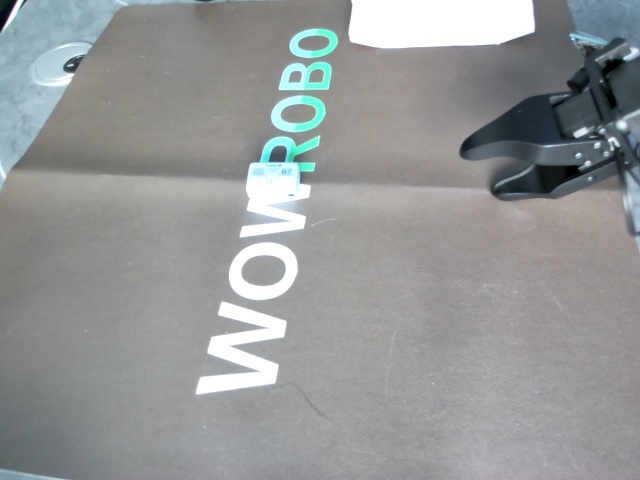

📸 cam1 view (E12 - top):


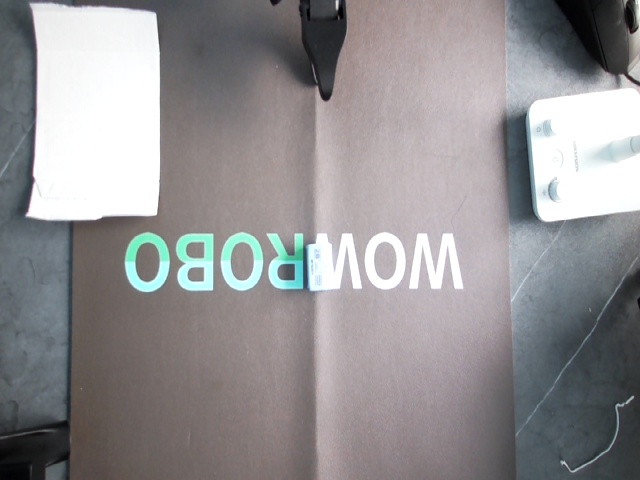

🤖 Leader joint angles: [ 91.23  116.895 173.584 -13.271  -8.35   34.893]
🤖 Follower joint angles: [ 91.758 129.551 172.529   0.352  -3.34   32.783]


In [7]:




from pathlib import Path
from IPython.display import display
from PIL import Image
import pickle
import numpy as np

# ✅ 设置 clip 路径（可改为任意 clip_xxxxx 文件夹）
clip_path = Path("/home/wjw/lerobot/results/recordings/clip_00001")
idx = 0  # 要查看的帧编号

# ✅ 读取图像路径
cam0_files = sorted((clip_path / "images_cam0").glob("*.jpg"))
cam1_files = sorted((clip_path / "images_cam1").glob("*.jpg"))

# ✅ 加载 joint_data.pkl
with open(clip_path / "joint_states" / "joint_data.pkl", "rb") as f:
    joint_data = pickle.load(f)

# ✅ 获取帧总数
num_frames = min(len(cam0_files), len(cam1_files), len(joint_data))

# ✅ 显示图像和关节数据
if idx < num_frames:
    img0 = Image.open(cam0_files[idx])
    img1 = Image.open(cam1_files[idx])

    timestamp, q_leader, q_follower = joint_data[idx]

    print("📅 Timestamp:", timestamp)
    print("📸 cam0 view (E22S - side):")
    display(img0)
    print("📸 cam1 view (E12 - top):")
    display(img1)

    print("🤖 Leader joint angles:", np.round(q_leader, 3))
    print("🤖 Follower joint angles:", np.round(q_follower, 3))
else:
    print(f"⚠️ Not enough frames to preview idx = {idx}")


In [11]:
from pathlib import Path
import pickle
import pandas as pd

# ✅ 根路径（根据你系统中路径更新）
data_root = Path("/home/wjw/lerobot/results/recordings")

# ✅ 获取所有 clip 文件夹
clip_folders = sorted([d for d in data_root.iterdir() if d.is_dir() and d.name.startswith("clip_")])

results = []

# ✅ 遍历每个 clip 检查图像和关节数据帧数是否一致
for clip_path in clip_folders:
    clip_name = clip_path.name

    cam0_dir = clip_path / "images_cam0"
    cam1_dir = clip_path / "images_cam1"
    joint_path = clip_path / "joint_states" / "joint_data.pkl"

    # 读取图像帧数
    cam0_count = len(list(cam0_dir.glob("*.jpg")))
    cam1_count = len(list(cam1_dir.glob("*.jpg")))

    # 读取 joint 数据帧数
    try:
        with open(joint_path, "rb") as f:
            joint_data = pickle.load(f)
        joint_count = len(joint_data)
    except Exception as e:
        joint_count = 0

    # 检查是否完全对齐
    aligned = (cam0_count == cam1_count == joint_count)

    results.append({
        "Clip": clip_name,
        "cam0_frames": cam0_count,
        "cam1_frames": cam1_count,
        "joint_frames": joint_count,
        "Aligned": "Yes" if aligned else "❌"
    })

# ✅ 转换为 DataFrame 并显示
df_sync = pd.DataFrame(results)
print("✅ 帧同步检测完成，结果如下：")
display(df_sync)

# ✅ 将 DataFrame 转为 LaTeX 表格格式
latex_table = df_sync.to_latex(index=False, caption="Frame Synchronization Summary", label="tab:sync_summary")

# ✅ 保存到指定路径
output_path = Path("/home/wjw/lerobot/results/recordings/frame_sync_summary.tex")
with open(output_path, "w") as f:
    f.write(latex_table)

print(f"📁 LaTeX 表格已保存至: {output_path}")


✅ 帧同步检测完成，结果如下：


,Clip,cam0_frames,cam1_frames,joint_frames,Aligned
0,clip_00001,379,379,379,Yes
1,clip_00002,433,433,433,Yes
2,clip_00003,377,377,377,Yes
3,clip_00004,523,523,523,Yes
4,clip_00005,347,347,347,Yes
5,clip_00006,412,412,412,Yes
6,clip_00007,486,486,486,Yes
7,clip_00008,402,402,402,Yes
8,clip_00009,388,388,388,Yes
9,clip_00010,349,349,349,Yes


📁 LaTeX 表格已保存至: /home/wjw/lerobot/results/recordings/frame_sync_summary.tex


In [12]:
import matplotlib.pyplot as plt

# ✅ 设置保存路径
save_path = Path("/home/wjw/lerobot/results/recordings/frame_sync_summary.png")

# ✅ 设置画布大小（根据行数可调整）
fig, ax = plt.subplots(figsize=(12, 0.4 * len(df_sync) + 2))

# ✅ 绘制表格（去掉索引）
ax.axis('off')
table = ax.table(cellText=df_sync.values,
                 colLabels=df_sync.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # 放大表格

# ✅ 保存为 PNG 图片
plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.close()

print(f"🖼️ 表格已保存为图片：{save_path}")


🖼️ 表格已保存为图片：/home/wjw/lerobot/results/recordings/frame_sync_summary.png


### 轨迹可视化代码

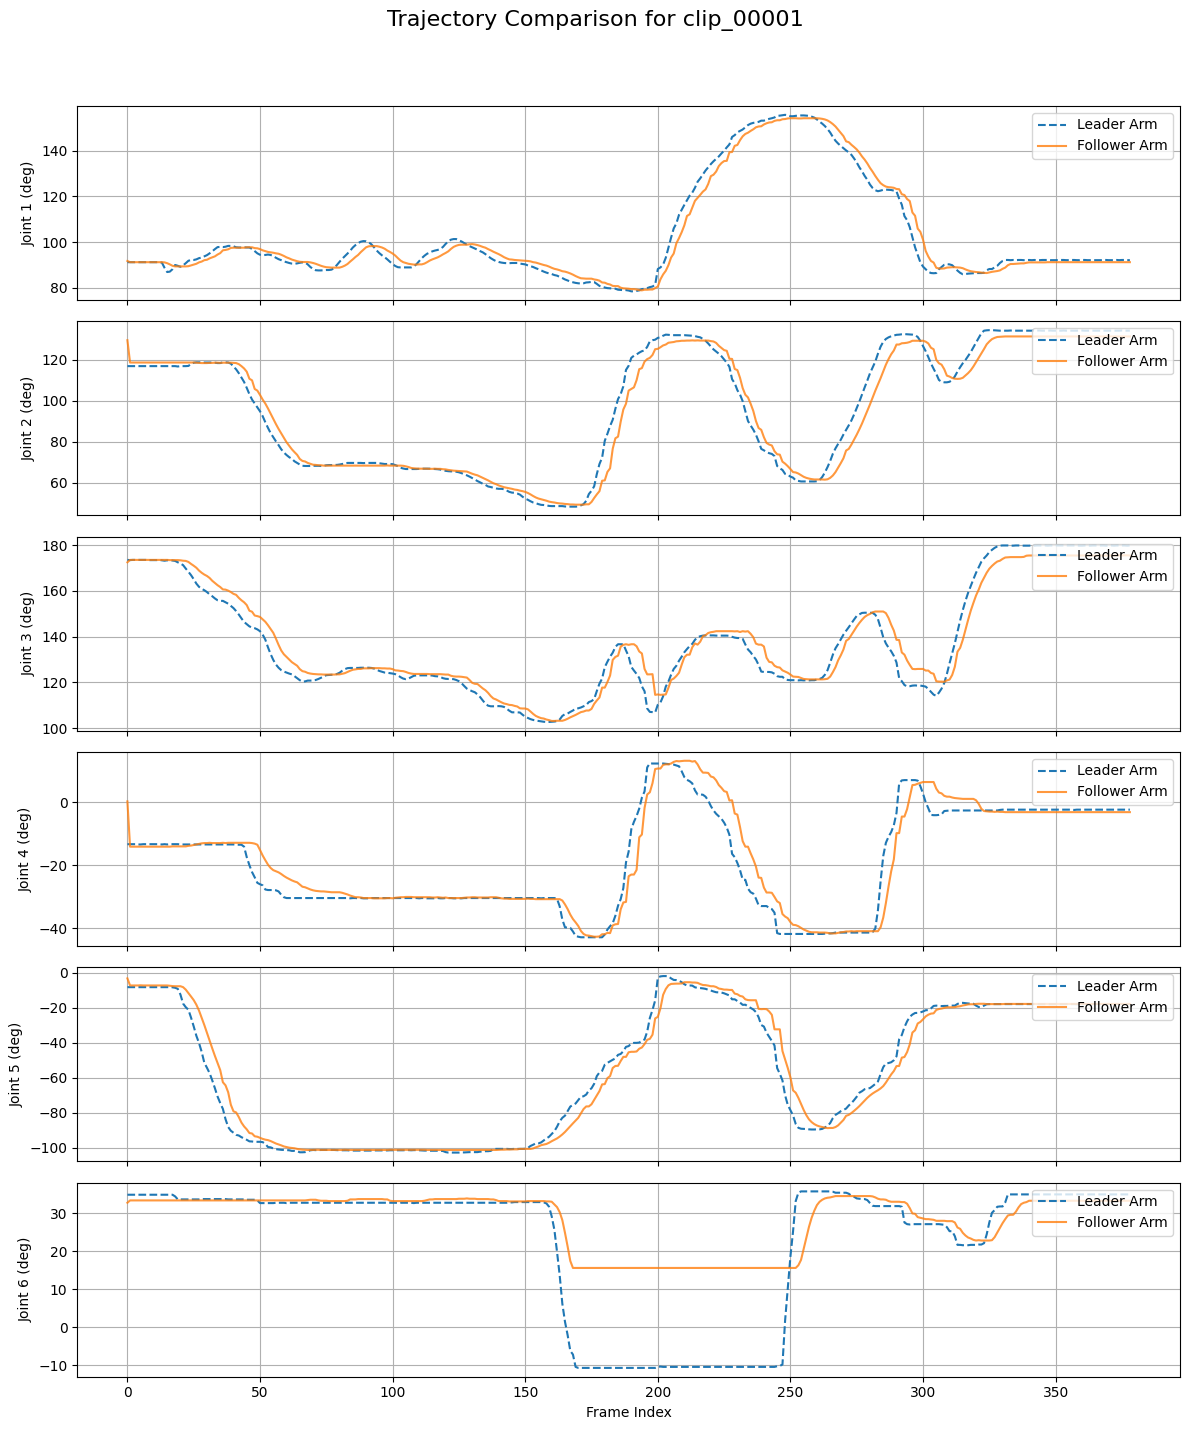

In [15]:


import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

# ✅ 设置 clip 路径（可更改为任意 clip）
clip_path = Path("/home/wjw/lerobot/results/recordings/clip_00001")
joint_file = clip_path / "joint_states" / "joint_data.pkl"

# ✅ 读取 joint_data.pkl
with open(joint_file, "rb") as f:
    joint_data = pickle.load(f)

# ✅ 提取 leader 和 follower 轨迹（忽略时间戳）
leader_trajectories = np.array([entry[1] for entry in joint_data])  # N x 6
follower_trajectories = np.array([entry[2] for entry in joint_data])
time = np.arange(len(leader_trajectories))  # 帧索引

# ✅ 获取关节数量（默认 6）
num_joints = leader_trajectories.shape[1]

# ✅ 可视化每个关节的主从轨迹
fig, axes = plt.subplots(num_joints, 1, figsize=(12, 2.5 * num_joints), sharex=True)
for j in range(num_joints):
    axes[j].plot(time, leader_trajectories[:, j], label="Leader Arm", linestyle='--')
    axes[j].plot(time, follower_trajectories[:, j], label="Follower Arm", alpha=0.8)
    axes[j].set_ylabel(f"Joint {j+1} (deg)")
    axes[j].legend(loc="upper right")
    axes[j].grid(True)

axes[-1].set_xlabel("Frame Index")
fig.suptitle(f"Trajectory Comparison for {clip_path.name}", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

data_root = Path("/home/wjw/lerobot/results/recordings")
clip_folders = sorted([d for d in data_root.iterdir() if d.is_dir() and d.name.startswith("clip_")])
save_dir = data_root / "trajectory_plots"
save_dir.mkdir(exist_ok=True)

for clip_path in clip_folders:
    joint_file = clip_path / "joint_states" / "joint_data.pkl"
    try:
        with open(joint_file, "rb") as f:
            joint_data = pickle.load(f)
        leader_trajectories = np.array([entry[1] for entry in joint_data])
        follower_trajectories = np.array([entry[2] for entry in joint_data])
        time = np.arange(len(leader_trajectories))
        num_joints = leader_trajectories.shape[1]
        fig, axes = plt.subplots(num_joints, 1, figsize=(12, 2.5 * num_joints), sharex=True)
        for j in range(num_joints):
            axes[j].plot(time, leader_trajectories[:, j], label="Leader Arm", linestyle='--')
            axes[j].plot(time, follower_trajectories[:, j], label="Follower Arm", alpha=0.8)
            axes[j].set_ylabel(f"Joint {j+1} (deg)")
            axes[j].legend(loc="upper right")
            axes[j].grid(True)
        axes[-1].set_xlabel("Frame Index")
        fig.suptitle(f"Trajectory Comparison for {clip_path.name}", fontsize=16)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig.savefig(save_dir / f"{clip_path.name}_trajectory.png", dpi=200)
        plt.close(fig)
    except Exception as e:
        print(f"❌ Failed to process {clip_path.name}: {e}")

print(f"✅ 所有轨迹图已保存至: {save_dir}")


✅ 所有轨迹图已保存至: /home/wjw/lerobot/results/recordings/trajectory_plots


### 主从机械臂关节角度误差分析（Position Error Analysis），

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import pandas as pd

# ✅ 设置根目录
data_root = Path("/home/wjw/lerobot/results/recordings")
clip_folders = sorted([d for d in data_root.iterdir() if d.is_dir() and d.name.startswith("clip_")])
save_dir = data_root / "error_analysis_plots"
save_dir.mkdir(exist_ok=True)

summary_list = []

# ✅ 遍历每个 clip 分析误差
for clip_path in clip_folders:
    joint_file = clip_path / "joint_states" / "joint_data.pkl"
    try:
        with open(joint_file, "rb") as f:
            joint_data = pickle.load(f)
        
        leader_trajectories = np.array([entry[1] for entry in joint_data])
        follower_trajectories = np.array([entry[2] for entry in joint_data])

        if leader_trajectories.shape != follower_trajectories.shape:
            print(f"❌ {clip_path.name} 数据维度不一致")
            continue

        errors = leader_trajectories - follower_trajectories
        num_joints = errors.shape[1]
        time = np.arange(errors.shape[0])

        # ✅ 可视化误差曲线
        fig, axes = plt.subplots(num_joints, 1, figsize=(12, 2.5 * num_joints), sharex=True)
        for j in range(num_joints):
            axes[j].plot(time, errors[:, j], label="Error", color="red")
            axes[j].axhline(0, color='black', linestyle='--', linewidth=0.8)
            axes[j].set_ylabel(f"Joint {j+1} Error (rad)")
            axes[j].grid(True)
        axes[-1].set_xlabel("Frame Index")
        fig.suptitle(f"Joint Angle Error: {clip_path.name}", fontsize=16)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig.savefig(save_dir / f"{clip_path.name}_error.png", dpi=200)
        plt.close(fig)

        # ✅ 保存 clip 级误差统计
        summary_list.append({
            "Clip": clip_path.name,
            **{f"Mean_J{i+1}": np.mean(errors[:, i]) for i in range(num_joints)},
            **{f"Max_J{i+1}": np.max(np.abs(errors[:, i])) for i in range(num_joints)},
            **{f"Std_J{i+1}": np.std(errors[:, i]) for i in range(num_joints)}
        })

    except Exception as e:
        print(f"❌ Failed to process {clip_path.name}: {e}")

# ✅ 汇总所有 clip 的误差统计表格
error_df_all = pd.DataFrame(summary_list)
csv_path = data_root / "error_summary_all.csv"
error_df_all.to_csv(csv_path, index=False)
print(f"✅ 所有误差图已保存至: {save_dir}")
print(f"✅ 汇总误差统计表已保存至: {csv_path}")


✅ 所有误差图已保存至: /home/wjw/lerobot/results/recordings/error_analysis_plots
✅ 汇总误差统计表已保存至: /home/wjw/lerobot/results/recordings/error_summary_all.csv


### 你这段代码用于分析主从机械臂的 角速度（joint velocity），也就是相邻帧之间的关节角度变化，用于评估控制的“平滑性”和“响应速度”。

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

# ✅ 设置根目录
data_root = Path("/home/wjw/lerobot/results/recordings")
clip_folders = sorted([d for d in data_root.iterdir() if d.is_dir() and d.name.startswith("clip_")])
save_dir = data_root / "velocity_plots"
save_dir.mkdir(exist_ok=True)

# ✅ 遍历每个 clip
for clip_path in clip_folders:
    joint_file = clip_path / "joint_states" / "joint_data.pkl"

    try:
        with open(joint_file, "rb") as f:
            joint_data = pickle.load(f)

        # 提取 leader / follower 轨迹
        leader_trajectories = np.array([entry[1] for entry in joint_data])
        follower_trajectories = np.array([entry[2] for entry in joint_data])

        if leader_trajectories.shape != follower_trajectories.shape:
            print(f"⚠️ {clip_path.name} 数据维度不一致，跳过。")
            continue

        # ✅ 计算角速度
        leader_velocity = np.diff(leader_trajectories, axis=0)
        follower_velocity = np.diff(follower_trajectories, axis=0)
        time = np.arange(len(leader_velocity))
        num_joints = leader_velocity.shape[1]

        # ✅ 绘制图像
        fig, axes = plt.subplots(num_joints, 1, figsize=(12, 2.5 * num_joints), sharex=True)
        for j in range(num_joints):
            axes[j].plot(time, leader_velocity[:, j], label="Leader Velocity", linestyle="--", color="blue")
            axes[j].plot(time, follower_velocity[:, j], label="Follower Velocity", linestyle="-", color="orange")
            axes[j].set_ylabel(f"Joint {j+1} vel (rad/frame)")
            axes[j].legend(loc="upper right")
            axes[j].grid(True)

        axes[-1].set_xlabel("Frame Index")
        fig.suptitle(f"Joint Velocity Analysis: {clip_path.name}", fontsize=16)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

        fig.savefig(save_dir / f"{clip_path.name}_velocity.png", dpi=200)
        plt.close(fig)

    except Exception as e:
        print(f"❌ Failed to process {clip_path.name}: {e}")

print(f"✅ 所有角速度图已保存至: {save_dir}")


✅ 所有角速度图已保存至: /home/wjw/lerobot/results/recordings/velocity_plots


### 非常好！你这段代码用于计算主从臂在每一帧的 关节角误差均方值（MSE），并可视化误差随时间的变化，用于评估模仿行为的整体稳定性和平滑度。



In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import pandas as pd

# ✅ 设置根目录
data_root = Path("/home/wjw/lerobot/results/recordings")
clip_folders = sorted([d for d in data_root.iterdir() if d.is_dir() and d.name.startswith("clip_")])
save_dir = data_root / "mse_plots"
save_dir.mkdir(exist_ok=True)

summary = []

# ✅ 遍历每个 clip 进行 MSE 分析
for clip_path in clip_folders:
    joint_file = clip_path / "joint_states" / "joint_data.pkl"

    try:
        with open(joint_file, "rb") as f:
            joint_data = pickle.load(f)

        leader = np.array([entry[1] for entry in joint_data])
        follower = np.array([entry[2] for entry in joint_data])

        if leader.shape != follower.shape:
            print(f"⚠️ {clip_path.name} 主从数据维度不一致，跳过")
            continue

        # ✅ 逐帧 MSE：每帧关节误差平方的均值
        mse_per_frame = np.mean((leader - follower) ** 2, axis=1)
        overall_mse = np.mean(mse_per_frame)

        # ✅ 保存图像
        plt.figure(figsize=(12, 4))
        plt.plot(mse_per_frame, label="MSE (rad²)", color='red')
        plt.xlabel("Frame Index")
        plt.ylabel("MSE")
        plt.title(f"MSE Over Time: {clip_path.name}")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(save_dir / f"{clip_path.name}_mse_curve.png", dpi=200)
        plt.close()

        summary.append({
            "Clip": clip_path.name,
            "Total Frames": len(mse_per_frame),
            "Overall MSE (rad^2)": overall_mse
        })

    except Exception as e:
        print(f"❌ Failed to process {clip_path.name}: {e}")

# ✅ 汇总输出 CSV 表格
df_mse = pd.DataFrame(summary)
csv_path = data_root / "mse_summary.csv"
df_mse.to_csv(csv_path, index=False)

print(f"✅ 所有 MSE 曲线图保存至: {save_dir}")
print(f"✅ 全局 MSE 表格保存至: {csv_path}")


✅ 所有 MSE 曲线图保存至: /home/wjw/lerobot/results/recordings/mse_plots
✅ 全局 MSE 表格保存至: /home/wjw/lerobot/results/recordings/mse_summary.csv


### ✅ 批量生成双视角视频（适配 LeRobot clip 结构）

In [19]:
import cv2
import pickle
from pathlib import Path

# ✅ 设置根路径，遍历所有 clip_xxxxx 文件夹
recording_root = Path("/home/wjw/lerobot/results/recordings")
clip_dirs = sorted([p for p in recording_root.glob("clip_*") if p.is_dir()])

# ✅ 视频参数
fps = 30
frame_size = (640, 480)
combined_size = (frame_size[0] * 2, frame_size[1])
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_color = (0, 255, 0)
thickness = 1

for clip_path in clip_dirs:
    cam0_dir = clip_path / "images_cam0"
    cam1_dir = clip_path / "images_cam1"
    joint_pkl = clip_path / "joint_states" / "joint_data.pkl"
    save_path = clip_path / "joint_overlay.mp4"

    if not joint_pkl.exists():
        print(f"❌ 跳过 {clip_path.name}，未找到 joint_data.pkl")
        continue

    try:
        with open(joint_pkl, "rb") as f:
            joint_data = pickle.load(f)
    except Exception as e:
        print(f"❌ 无法读取 {clip_path.name} 的 joint_data.pkl: {e}")
        continue

    video_writer = cv2.VideoWriter(str(save_path), fourcc, fps, combined_size)
    written = 0

    for i, (timestamp, leader, follower) in enumerate(joint_data):
        img_path_cam0 = cam0_dir / f"frame_{i:05d}.jpg"
        img_path_cam1 = cam1_dir / f"frame_{i:05d}.jpg"

        if not img_path_cam0.exists() or not img_path_cam1.exists():
            continue

        img0 = cv2.imread(str(img_path_cam0))
        img1 = cv2.imread(str(img_path_cam1))
        if img0 is None or img1 is None:
            continue

        img0 = cv2.resize(img0, frame_size)
        img1 = cv2.resize(img1, frame_size)
        combined_img = cv2.hconcat([img0, img1])

        lines = [f"Frame {i:03d}"]
        for j in range(6):
            lines.append(f"L-J{j+1}: {leader[j]:.1f}, F-J{j+1}: {follower[j]:.1f}")

        for j, text in enumerate(lines):
            cv2.putText(combined_img, text, (10, 25 + j * 20), font, font_scale, font_color, thickness, cv2.LINE_AA)

        video_writer.write(combined_img)
        written += 1

    video_writer.release()
    print(f"✅ [{clip_path.name}] 成功写入视频帧数: {written}，保存为: {save_path.name}")


✅ [clip_00001] 成功写入视频帧数: 379，保存为: joint_overlay.mp4
✅ [clip_00002] 成功写入视频帧数: 433，保存为: joint_overlay.mp4
✅ [clip_00003] 成功写入视频帧数: 377，保存为: joint_overlay.mp4
✅ [clip_00004] 成功写入视频帧数: 523，保存为: joint_overlay.mp4
✅ [clip_00005] 成功写入视频帧数: 347，保存为: joint_overlay.mp4
✅ [clip_00006] 成功写入视频帧数: 412，保存为: joint_overlay.mp4
✅ [clip_00007] 成功写入视频帧数: 486，保存为: joint_overlay.mp4
✅ [clip_00008] 成功写入视频帧数: 402，保存为: joint_overlay.mp4
✅ [clip_00009] 成功写入视频帧数: 388，保存为: joint_overlay.mp4
✅ [clip_00010] 成功写入视频帧数: 349，保存为: joint_overlay.mp4
✅ [clip_00011] 成功写入视频帧数: 390，保存为: joint_overlay.mp4
✅ [clip_00012] 成功写入视频帧数: 404，保存为: joint_overlay.mp4
✅ [clip_00013] 成功写入视频帧数: 464，保存为: joint_overlay.mp4
✅ [clip_00014] 成功写入视频帧数: 437，保存为: joint_overlay.mp4
✅ [clip_00015] 成功写入视频帧数: 382，保存为: joint_overlay.mp4
✅ [clip_00016] 成功写入视频帧数: 423，保存为: joint_overlay.mp4
✅ [clip_00017] 成功写入视频帧数: 376，保存为: joint_overlay.mp4
✅ [clip_00018] 成功写入视频帧数: 415，保存为: joint_overlay.mp4
✅ [clip_00019] 成功写入视频帧数: 424，保存为: joint_overlay.mp4
✅ [clip_0002

### 误差动态热图”

✅ 动态误差热图已保存至: /home/wjw/lerobot/results/recordings/clip_00001/error_heatmap.mp4


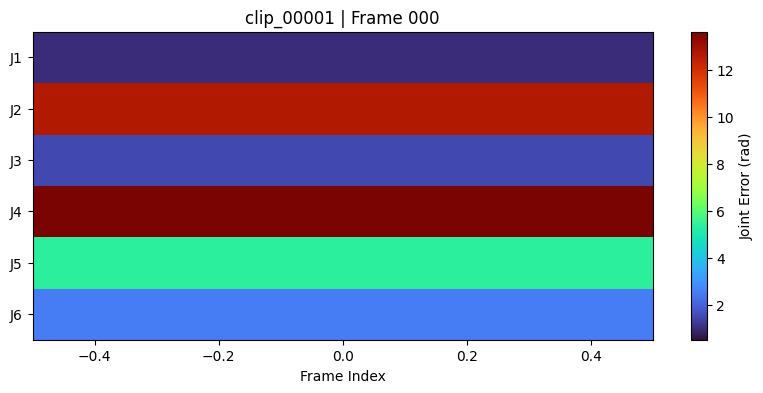

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
import pickle

# ✅ 设置要处理的 clip（你也可以批量处理所有）
clip_path = Path("/home/wjw/lerobot/results/recordings/clip_00001")
pkl_path = clip_path / "joint_states/joint_data.pkl"
save_path = clip_path / "error_heatmap.mp4"

# ✅ 读取 joint_data.pkl
with open(pkl_path, "rb") as f:
    joint_data = pickle.load(f)

# ✅ 提取主从关节角度
leader = np.array([entry[1] for entry in joint_data])  # N x 6
follower = np.array([entry[2] for entry in joint_data])

# ✅ 计算逐帧误差（绝对值）
errors = np.abs(leader - follower).T  # shape: 6 x N (便于热图显示)

# ✅ 设置热图动画保存路径
fig, ax = plt.subplots(figsize=(10, 4))
cax = ax.imshow(errors[:, :1], aspect='auto', cmap='turbo', interpolation='nearest')
cb = fig.colorbar(cax)
cb.set_label("Joint Error (rad)")

ax.set_yticks(range(6))
ax.set_yticklabels([f"J{i+1}" for i in range(6)])
ax.set_xlabel("Frame Index")

# ✅ 更新函数（动态归一化颜色）
def update(frame):
    ax.clear()
    current_error = errors[:, :frame+1]
    vmax = np.max(current_error)
    cax = ax.imshow(current_error, aspect='auto', cmap='turbo', vmin=0, vmax=max(vmax, 1e-3))
    ax.set_title(f"{clip_path.name} | Frame {frame:03d}")
    ax.set_yticks(range(6))
    ax.set_yticklabels([f"J{i+1}" for i in range(6)])
    ax.set_xlabel("Frame Index")
    return [cax]

# ✅ 创建动画
ani = animation.FuncAnimation(fig, update, frames=errors.shape[1], interval=40, blit=False)

# ✅ 保存为 MP4
save_path.parent.mkdir(exist_ok=True, parents=True)
ani.save(save_path, fps=25, dpi=200)
print(f"✅ 动态误差热图已保存至: {save_path}")


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

# ✅ 设置根目录，遍历所有 clip 文件夹
recording_root = Path("/home/wjw/lerobot/results/recordings")
clip_dirs = sorted([p for p in recording_root.glob("clip_*") if p.is_dir()])

for clip_path in clip_dirs:
    joint_path = clip_path / "joint_states/joint_data.pkl"
    save_path = clip_path / "error_heatmap.png"

    if not joint_path.exists():
        print(f"⚠️ 跳过 {clip_path.name}，joint_data.pkl 不存在")
        continue

    try:
        with open(joint_path, "rb") as f:
            joint_data = pickle.load(f)
    except Exception as e:
        print(f"❌ 读取失败 {clip_path.name}: {e}")
        continue

    # ✅ 提取 leader 和 follower 数据
    leader = np.array([entry[1] for entry in joint_data])
    follower = np.array([entry[2] for entry in joint_data])
    errors = np.abs(leader - follower).T  # shape: 6 x N

    # ✅ 绘制静态热力图
    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(errors, aspect='auto', cmap='turbo', interpolation='nearest')
    cbar = fig.colorbar(im)
    cbar.set_label("Joint Error (rad)")

    ax.set_title(f"{clip_path.name} - Static Joint Error Heatmap")
    ax.set_yticks(range(6))
    ax.set_yticklabels([f"J{i+1}" for i in range(6)])
    ax.set_xlabel("Frame Index")

    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.close()

    print(f"✅ 生成静态热图: {save_path.name}")


✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heatmap.png
✅ 生成静态热图: error_heat

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import shutil

# ✅ 根路径：遍历所有 clip 文件夹
recording_root = Path("/home/wjw/lerobot/results/recordings")
clip_dirs = sorted([p for p in recording_root.glob("clip_*") if p.is_dir()])

# ✅ 统一输出路径
output_dir = Path("/home/wjw/lerobot/results/error_heatmaps")
output_dir.mkdir(parents=True, exist_ok=True)

for clip_path in clip_dirs:
    joint_path = clip_path / "joint_states/joint_data.pkl"
    clip_name = clip_path.name
    save_path = output_dir / f"{clip_name}_error_heatmap.png"

    if not joint_path.exists():
        print(f"⚠️ 跳过 {clip_name}，joint_data.pkl 不存在")
        continue

    try:
        with open(joint_path, "rb") as f:
            joint_data = pickle.load(f)
    except Exception as e:
        print(f"❌ 读取失败 {clip_name}: {e}")
        continue

    leader = np.array([entry[1] for entry in joint_data])
    follower = np.array([entry[2] for entry in joint_data])
    errors = np.abs(leader - follower).T  # shape: 6 x N

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(errors, aspect='auto', cmap='turbo', interpolation='nearest')
    cbar = fig.colorbar(im)
    cbar.set_label("Joint Error (rad)")

    ax.set_title(f"{clip_name} - Static Joint Error Heatmap")
    ax.set_yticks(range(6))
    ax.set_yticklabels([f"J{i+1}" for i in range(6)])
    ax.set_xlabel("Frame Index")

    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.close()

    print(f"✅ 热图已保存：{save_path.name}")


✅ 热图已保存：clip_00001_error_heatmap.png
✅ 热图已保存：clip_00002_error_heatmap.png
✅ 热图已保存：clip_00003_error_heatmap.png
✅ 热图已保存：clip_00004_error_heatmap.png
✅ 热图已保存：clip_00005_error_heatmap.png
✅ 热图已保存：clip_00006_error_heatmap.png
✅ 热图已保存：clip_00007_error_heatmap.png
✅ 热图已保存：clip_00008_error_heatmap.png
✅ 热图已保存：clip_00009_error_heatmap.png
✅ 热图已保存：clip_00010_error_heatmap.png
✅ 热图已保存：clip_00011_error_heatmap.png
✅ 热图已保存：clip_00012_error_heatmap.png
✅ 热图已保存：clip_00013_error_heatmap.png
✅ 热图已保存：clip_00014_error_heatmap.png
✅ 热图已保存：clip_00015_error_heatmap.png
✅ 热图已保存：clip_00016_error_heatmap.png
✅ 热图已保存：clip_00017_error_heatmap.png
✅ 热图已保存：clip_00018_error_heatmap.png
✅ 热图已保存：clip_00019_error_heatmap.png
✅ 热图已保存：clip_00020_error_heatmap.png
✅ 热图已保存：clip_00021_error_heatmap.png
✅ 热图已保存：clip_00022_error_heatmap.png
✅ 热图已保存：clip_00023_error_heatmap.png
✅ 热图已保存：clip_00024_error_heatmap.png
✅ 热图已保存：clip_00025_error_heatmap.png
✅ 热图已保存：clip_00026_error_heatmap.png
✅ 热图已保存：clip_00027_error_heatmap.png
✅

### 阶段四：模仿学习ACT算法


In [17]:
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader



In [18]:
#✅ Cell 2: 设置路径并加载数据s/policy/act_state_only.yaml

data_root = Path("/home/wjw/lerobot/results/recordings")
data_files = sorted(data_root.glob("clip_*/joint_states/state_action.npy"))
print(f"📂 共载入 {len(data_files)} 条记录")

states, actions = [], []
for f in data_files:
    data = np.load(f, allow_pickle=True)
    states.append(data[:, :6])
    actions.append(data[:, 6:])
states = np.concatenate(states, axis=0)
actions = np.concatenate(actions, axis=0)

print(f"✅ 合并数据完成: 状态维度: {states.shape}, 动作维度: {actions.shape}")


📂 共载入 10 条记录
✅ 合并数据完成: 状态维度: (4096, 6), 动作维度: (4096, 6)


In [19]:
#✅ Cell 3: 构建 chunk 序列

chunk_size = 10
X, y = [], []
for i in range(len(states) - chunk_size):
    X.append(states[i:i+chunk_size])
    y.append(actions[i+chunk_size-1])
X = np.array(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
print(f"✅ 划分训练/验证集: 训练样本: {len(X_train)}, 验证样本: {len(X_val)}")


✅ 划分训练/验证集: 训练样本: 3268, 验证样本: 818


In [20]:
#✅ Cell 4: 封装数据集与 DataLoade
class ACTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(ACTDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ACTDataset(X_val, y_val), batch_size=batch_size)


In [23]:
#✅ Cell 5: 定义 Transformer 模型（ACT）
class ACTModel(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, num_heads=4, num_layers=2, out_dim=6):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        x = self.input_proj(x)
        x = self.encoder(x)
        return self.output(x[:, -1])  # 取最后一个时间步的输出

model = ACTModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [24]:
#✅ Cell 6: 启动训练
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        pred = model(Xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 验证
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            val_loss += criterion(model(Xb), yb).item()

    print(f"📈 Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")


📈 Epoch 1/100 | Train Loss: 365247.5327 | Val Loss: 84915.6543
📈 Epoch 2/100 | Train Loss: 307346.9614 | Val Loss: 69655.5659
📈 Epoch 3/100 | Train Loss: 245249.8130 | Val Loss: 54204.2288
📈 Epoch 4/100 | Train Loss: 187198.4106 | Val Loss: 40287.0815
📈 Epoch 5/100 | Train Loss: 135687.6282 | Val Loss: 28864.7218
📈 Epoch 6/100 | Train Loss: 96724.1829 | Val Loss: 20332.7584
📈 Epoch 7/100 | Train Loss: 67569.9891 | Val Loss: 14560.9286
📈 Epoch 8/100 | Train Loss: 49868.0167 | Val Loss: 10942.2969
📈 Epoch 9/100 | Train Loss: 38616.2542 | Val Loss: 8593.1486
📈 Epoch 10/100 | Train Loss: 30105.8394 | Val Loss: 6832.5207
📈 Epoch 11/100 | Train Loss: 24252.4711 | Val Loss: 5711.1033
📈 Epoch 12/100 | Train Loss: 19613.8787 | Val Loss: 4396.5287
📈 Epoch 13/100 | Train Loss: 15667.3294 | Val Loss: 3444.0417
📈 Epoch 14/100 | Train Loss: 12513.9025 | Val Loss: 2739.1946
📈 Epoch 15/100 | Train Loss: 10055.0556 | Val Loss: 2270.1032
📈 Epoch 16/100 | Train Loss: 8405.3112 | Val Loss: 1933.0869
📈 Epo

In [26]:
# 🧠 Cell 7: 保存模型 保存权重
save_path = Path("models/act_model_static_grasp.pth")
save_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"✅ 模型已保存到: {save_path}")


✅ 模型已保存到: models/act_model_static_grasp.pth


In [27]:
# 🧪 Cell 8: 加载模型并推理测试（单次测试）加载模型
model = ACTModel()
model.load_state_dict(torch.load(save_path))
model.eval()

# 从验证集随机挑选一个样本进行推理
idx = np.random.randint(len(X_val))
sample_input = torch.tensor(X_val[idx:idx+1], dtype=torch.float32)
ground_truth = y_val[idx]

with torch.no_grad():
    pred_action = model(sample_input).squeeze().numpy()

print("🎯 Ground Truth:", np.round(ground_truth, 2))
print("🤖 Predicted Action:", np.round(pred_action, 2))


🎯 Ground Truth: [ 87.8  112.59 109.07  40.34 -13.1   19.42]
🤖 Predicted Action: [ 88.92 115.56 111.97  39.34 -10.91  20.16]


### 阶段 5：部署 ACT 模型到 LeRobot 实物控制

In [32]:
state_dict = torch.load("models/act_model_static_grasp.pth")
print(state_dict.keys())


odict_keys(['input_proj.weight', 'input_proj.bias', 'encoder.layers.0.self_attn.in_proj_weight', 'encoder.layers.0.self_attn.in_proj_bias', 'encoder.layers.0.self_attn.out_proj.weight', 'encoder.layers.0.self_attn.out_proj.bias', 'encoder.layers.0.linear1.weight', 'encoder.layers.0.linear1.bias', 'encoder.layers.0.linear2.weight', 'encoder.layers.0.linear2.bias', 'encoder.layers.0.norm1.weight', 'encoder.layers.0.norm1.bias', 'encoder.layers.0.norm2.weight', 'encoder.layers.0.norm2.bias', 'encoder.layers.1.self_attn.in_proj_weight', 'encoder.layers.1.self_attn.in_proj_bias', 'encoder.layers.1.self_attn.out_proj.weight', 'encoder.layers.1.self_attn.out_proj.bias', 'encoder.layers.1.linear1.weight', 'encoder.layers.1.linear1.bias', 'encoder.layers.1.linear2.weight', 'encoder.layers.1.linear2.bias', 'encoder.layers.1.norm1.weight', 'encoder.layers.1.norm1.bias', 'encoder.layers.1.norm2.weight', 'encoder.layers.1.norm2.bias', 'output.weight', 'output.bias'])


In [31]:
# ✅ Cell 9：加载 Transformer 版 ACT 模型（匹配你训练保存的模型）
import torch
import torch.nn as nn

class ACTTransformer(nn.Module):
    def __init__(self, input_dim=6, output_dim=6, dim=128, depth=2, heads=4, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.output = nn.Linear(dim, output_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        return self.output(x[:, -1])  # 只用最后一步作为输出

# === 实例化模型 & 加载参数 ===
model = ACTTransformer()
model.load_state_dict(torch.load("models/act_model_static_grasp.pth"))
model.eval()

print("✅ 模型结构和参数加载成功，准备部署控制机械臂")


✅ 模型结构和参数加载成功，准备部署控制机械臂


In [1]:
# 你目前的部署流程可以总结为：

# 1. 使用 state_action.npy 中的关节状态序列（Leader 状态作为输入）
# python
# 复制
# 编辑
# states = state_action[:, :6]  # leader_pos
# 2. 基于 Transformer 模型（ACT）进行多步动作预测
# python
# 复制
# 编辑
# input_tensor = torch.tensor([input_seq], dtype=torch.float32)
# pred_action = model(input_tensor).numpy().flatten()
# 3. 让从臂执行预测的动作
# python
# 复制
# 编辑
# robot.follower_arms["main"].write("Goal_Position", pred_action.tolist())
目前 仅仅基于关节角度数据训练和预测动作，这意味着模型 只能在相同起始状态、相同目标物体位置时工作。




SyntaxError: invalid character '，' (U+FF0C) (2147991893.py, line 19)

In [49]:
# ✅ Cell 10：使用模型控制机械臂执行动作
import time
import torch
import numpy as np

# === 设置参数 ===
clip_dir = "recordings/clip_00008/joint_states"  # ✅ 修改为你想回放的 clip 路径
model.eval()

# === 加载数据（state-action 格式） ===
state_action = np.load(f"{clip_dir}/state_action.npy", allow_pickle=True)  # ✅ 注意这里
states = state_action[:, :6]  # 只用状态作为输入

# === 初始化输入序列（上下文窗口） ===
context_len = 10
input_seq = []

print("🤖 正在部署模型控制机械臂...")

for t in range(len(states)):
    # === 更新输入序列 ===
    input_seq.append(states[t])
    if len(input_seq) < context_len:
        continuestate-action 数据训练 ACT 模型
    if len(input_seq) > context_len:
        input_seq.pop(0)

    input_tensor = torch.tensor([input_seq], dtype=torch.float32)  # shape: (1, T, 6)
    with torch.no_grad():
        pred_action = model(input_tensor).numpy().flatten()

    # === 写入从动臂目标位置 ===
    robot.follower_arms["main"].write("Goal_Position", pred_action.tolist())
    time.sleep(0.05)  # 控制频率，避免过快

print("✅ 模型执行完成，机械臂动作已复现！")


🤖 正在部署模型控制机械臂...
✅ 模型执行完成，机械臂动作已复现！


🖼️ 正在展示图像序列（每 10 帧显示）


/tmp/ipykernel_17315/3382202076.py:41: UserWarning: Glyph 24103 (\N{CJK UNIFIED IDEOGRAPH-5E27}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_17315/3382202076.py:41: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_17315/3382202076.py:41: UserWarning: Glyph 35282 (\N{CJK UNIFIED IDEOGRAPH-89D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_17315/3382202076.py:41: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_17315/3382202076.py:41: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_17315/3382202076.py:41: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_17315/3382202076.py:41: UserWarning: Glyph 33410 (\N{CJK UNIFIED IDEOGRAP

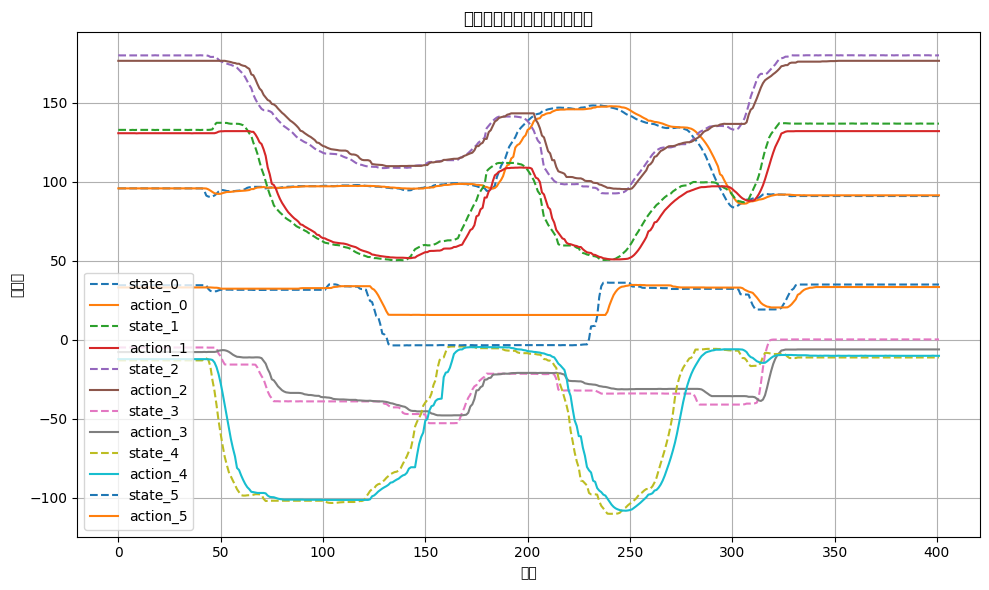

In [48]:
# ✅ Cell 11：可视化模型复现过程（图像 + 轨迹对比）
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import cv2

# === 设置路径 ===
clip_dir = Path("recordings/clip_00008")  # ✅ 改成你想回放的路径
img_dir0 = clip_dir / "images_cam0"
img_dir1 = clip_dir / "images_cam1"
joint_path = clip_dir / "joint_states" / "state_action.npy"

# === 加载关节轨迹 ===
data = np.load(joint_path, allow_pickle=True)
states = data[:, :6]
actions = data[:, 6:]

# === 显示部分图像帧（每隔10帧显示一张） ===
print("🖼️ 正在展示图像序列（每 10 帧显示）")
for i in range(0, len(states), 10):
    frame0 = cv2.imread(str(img_dir0 / f"frame_{i:05d}.jpg"))
    frame1 = cv2.imread(str(img_dir1 / f"frame_{i:05d}.jpg"))

    if frame0 is not None and frame1 is not None:
        combined = cv2.hconcat([frame0, frame1])
        cv2.imshow("Replay View (Left: Side | Right: Top)", combined)
        if cv2.waitKey(300) & 0xFF == ord("q"):  # 按 Q 提前退出
            break
cv2.destroyAllWindows()

# === 绘制轨迹对比图 ===
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(states[:, i], label=f"state_{i}", linestyle="--")
    plt.plot(actions[:, i], label=f"action_{i}")
plt.title("关节状态与预测动作轨迹对比")
plt.xlabel("帧数")
plt.ylabel("角度值")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 要实现“任意位置物体抓取”的关键变化
你必须加入 视觉信息作为模型的输入，这样模型才能根据图像推断物体位置、再做出对应动作。
✅ 你的目标
实现一个低成本系统，使得 LeRobot 能：

🚀 自主完成：无需人为控制

📍 抓取工作空间内任意位置的该物体

📦 物体种类不变（同一方块）

✅ 支持 2D 平面上的位置变化（X/Y 变，Z 不变

### 🧠 3. 模型“泛化能力”的本质是什么？
你说得对：

❗训练数据中只有 4 个固定位置 → 模型也只能学会“在这4个空间位置”如何抓取。

如果你把物体放在：

✅ 训练过的位置附近 → 模型可能抓得准（比如 clip_0011 和 clip_0012 之间插值）

❌ 没见过的新区域（比如 clip_0050 位置） → 完全不知道物体在哪儿，只能瞎抓

📷 4. 没有图片，那机器人是“瞎子”！
所以，光靠关节状态做训练的模型无法定位新物体位置，因为：

它没有 任何视觉输入

它无法像人一样观察环境，判断物体的新位置

就像你训练了一个小孩：告诉他“你在这个姿态时，往前伸手可以抓到杯子”，但没有教他如何“找到杯子”，他就只能在记忆中找抓法，而不是感知现实。

### 
1. 仅使用关节数据训练 ACT 模型
数据内容：你当前40组数据中，每个 clip 包含了机器人抓取时的关节状态与动作（state-action 数据）。

训练效果：

模型会学习如何从过去的状态序列预测下一步动作。

如果你只训练关节数据，那么模型“记住”的就是那些训练过的位置和轨迹，能够在那些位置上较好地复现抓取动作。

局限性：

模型不会“知道”物体在哪里，因为关节数据只反映了机器人在执行预设动作时的姿态，而不包含环境信息。

如果你把物体放在一个未采集过的位置，模型无法感知物体的新位置，只能复现训练过的抓取轨迹，导致抓取失败或偏差。

2. 使用视觉数据+关节数据训练视觉模仿模型
数据内容：在你当前采集的每个 clip 中，除了关节状态之外，还采集了两路图像（侧视和俯视）。

训练效果：

如果你将图像数据与关节数据联合起来训练模型，那么模型可以学习到如何根据视觉信息判断物体的位置，再结合关节状态给出合适的抓取动作。

这种方式能够让机器人在物体出现在未训练位置时，根据视觉反馈进行相应的调整，实现更强的泛化能力。

实现挑战：

需要设计一个多模态网络结构（例如先用 CNN/ViT 提取图像特征，再与关节状态融合，输入到 Transformer 模型中）。

数据预处理和对齐要求更高，训练时间和算力消耗也会增加。

### 阶段六：非常好！现在你已经完成了关键的静态抓取数据采集，接下来我们可以 一步步开始训练视觉引导的 ACT 策略模型，以便让 LeRobot 实现“自主抓取任意位置物体”的能力。

✅ 阶段目标：
使用你采集的 40 组多位置抓取数据，训练一个融合图像 + 关节信息的 Transformer 模型（ACTPolicy），完成视觉引导的模仿学习。

In [66]:
from pathlib import Path

recording_dir = Path("/home/wjw/lerobot/results/recordings")
clips = sorted(recording_dir.glob("clip_*"))
print(f"找到 {len(clips)} 个 clip 文件夹")

找到 40 个 clip 文件夹


In [64]:
import os
import shutil
import json
from pathlib import Path
from tqdm import tqdm


def convert_clip_to_lerobot_dataset(recording_dir, output_dir):
    """
    将采集的 clip 文件夹转换为 LeRobotDataset 所需的结构。
    输入是一个 recordings 文件夹，输出是标准结构的数据集。
    """
    recording_dir = Path(recording_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for clip_dir in tqdm(sorted(recording_dir.glob("clip_*"))):
        clip_name = clip_dir.name
        new_clip_path = output_dir / clip_name / "observation"
        (new_clip_path / "images" / "cam0").mkdir(parents=True, exist_ok=True)
        (new_clip_path / "images" / "cam1").mkdir(parents=True, exist_ok=True)

        # 复制图像
        for cam_id in ["cam0", "cam1"]:
            img_dir = clip_dir / f"images_{cam_id}"
            if img_dir.exists():
                for img_file in sorted(img_dir.glob("*.jpg")):
                    shutil.copy(img_file, new_clip_path / "images" / cam_id / img_file.name)

        # 复制 joint_states 中的 .npy 文件
        joint_dir = clip_dir / "joint_states"
        shutil.copy(joint_dir / "state_action.npy", output_dir / clip_name / "action.npy")
        shutil.copy(joint_dir / "state_action.npy", output_dir / clip_name / "state.npy")  # 同一个用于输入输出

        # 创建 meta.yaml（最简格式）
        with open(output_dir / clip_name / "meta.yaml", "w") as f:
            json.dump({
                "fps": 30,
                "camera_names": ["cam0", "cam1"],
                "state_dim": 6,
                "action_dim": 6
            }, f)

    print("✅ 所有 clip 数据已转换为 LeRobotDataset 格式！")


In [65]:
convert_clip_to_lerobot_dataset(
    recording_dir="/home/wjw/lerobot/results/recordings",
    output_dir="/home/wjw/lerobot/results/lerobot_dataset"
)



100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 18.54it/s]

✅ 所有 clip 数据已转换为 LeRobotDataset 格式！


In [71]:
! tree /home/wjw/lerobot/results/lerobot_dataset/clip_00001




/home/wjw/lerobot/results/lerobot_dataset/clip_00001
├── action.npy
├── meta.yaml
├── observation
│   └── images
│       ├── cam0
│       │   ├── frame_00000.jpg
│       │   ├── frame_00001.jpg
│       │   ├── frame_00002.jpg
│       │   ├── frame_00003.jpg
│       │   ├── frame_00004.jpg
│       │   ├── frame_00005.jpg
│       │   ├── frame_00006.jpg
│       │   ├── frame_00007.jpg
│       │   ├── frame_00008.jpg
│       │   ├── frame_00009.jpg
│       │   ├── frame_00010.jpg
│       │   ├── frame_00011.jpg
│       │   ├── frame_00012.jpg
│       │   ├── frame_00013.jpg
│       │   ├── frame_00014.jpg
│       │   ├── frame_00015.jpg
│       │   ├── frame_00016.jpg
│       │   ├── frame_00017.jpg
│       │   ├── frame_00018.jpg
│       │   ├── frame_00019.jpg
│       │   ├── frame_00020.jpg
│       │   ├── frame_00021.jpg
│       │   ├── frame_00022.jpg
│       │   ├── frame_00023.jpg
│       │   ├── frame_00024.jpg
│       │   ├── frame_00025.jpg
│       │   ├── frame_00026.jpg
│     

In [70]:
!nvidia-smi


Tue Apr  1 01:51:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P4              9W /   80W |     540MiB /   8188MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [72]:
import torch

if torch.cuda.is_available():
    print("✅ 当前系统支持 CUDA！将使用 GPU 进行训练。")
    print("🖥️ 当前使用的 GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ 当前系统不支持 CUDA，仅能使用 CPU 训练。")
    print("🧠 训练速度可能较慢，建议检查 GPU 驱动或安装 CUDA 支持版本。")



✅ 当前系统支持 CUDA！将使用 GPU 进行训练。
🖥️ 当前使用的 GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [74]:
import os

# 切换到 lerobot 项目根目录
os.chdir("/home/wjw/lerobot")

# 打印当前路径确认
print("📂 当前路径：", os.getcwd())


📂 当前路径： /home/wjw/lerobot


In [75]:
# ✅ Cell 1：设置训练参数与基本信息
import os
from pathlib import Path

# 项目根路径
project_root = Path("/home/wjw/lerobot")
results_root = project_root / "results"
recordings_dir = results_root / "recordings"
dataset_dir = results_root / "lerobot_dataset"

# 配置参数
policy_name = "act_koch_real"
env_name = "koch_real"
dataset_repo_id = "wjw_user/koch_static_v1"
ckpt_dir = project_root / "outputs" / "train" / "act_koch_test"
ckpt_dir.mkdir(parents=True, exist_ok=True)

# 设备设置（建议使用 GPU）
device = "cuda"  # 如果没有 GPU，可改为 "cpu"
print("✅ 配置完成，准备开始训练")
print("📁 数据路径:", dataset_dir)
print("📁 输出路径:", ckpt_dir)



✅ 配置完成，准备开始训练
📁 数据路径: /home/wjw/lerobot/results/lerobot_dataset
📁 输出路径: /home/wjw/lerobot/outputs/train/act_koch_test


In [82]:
# ✅ 修复后 Cell 2：删除不支持的 --device 参数
import subprocess

command = [
    "python", "lerobot/scripts/train.py",
    "--dataset.repo_id", "wjw_user/koch_static_v1",
    "--policy", "act_koch_real",
    "--env", "koch_real",
    "--wandb.enable", "false",
    "--output_dir", "outputs/train/act_koch_test",
    "--job_name", "act_koch_test"
]

print("🚀 开始训练，请耐心等待...（预计几分钟至十几分钟）")
print("📟 命令：", " ".join(command))

process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
for line in process.stdout:
    print(line, end="")
process.wait()

print("\n✅ 训练结束，模型保存在：outputs/train/act_koch_test/checkpoints/last/pretrained_model")


🚀 开始训练，请耐心等待...（预计几分钟至十几分钟）
📟 命令： python lerobot/scripts/train.py --dataset.repo_id wjw_user/koch_static_v1 --policy act_koch_real --env koch_real --wandb.enable false --output_dir outputs/train/act_koch_test --job_name act_koch_test
Traceback (most recent call last):
  File "/home/wjw/miniconda3/envs/lerobot/lib/python3.10/site-packages/draccus/parsers/decoding.py", line 357, in _try_functions
    return func(val, path)
  File "/home/wjw/miniconda3/envs/lerobot/lib/python3.10/site-packages/draccus/parsers/decoding.py", line 180, in decode_choice_class
    raise ParsingError(f"Expected a dict for a choice class, got {raw_value}")
draccus.utils.ParsingError: Expected a dict for a choice class, got koch_real

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/wjw/lerobot/lerobot/scripts/train.py", line 288, in <module>
    train()
  File "/home/wjw/lerobot/lerobot/configs/parser.py", line 226, in wrapper_inner
    cfg = 

In [83]:
import subprocess

command = [
    "python", "lerobot/scripts/train.py",
    "--config_path", "lerobot/configs/policy/act_koch_real.yaml",
    "--dataset.repo_id", "wjw_user/koch_static_v1",
    "--output_dir", "outputs/train/act_koch_test",
    "--job_name", "act_koch_test",
    "--wandb.enable", "false"
]

print("🚀 正在训练视觉引导 ACT 模型，请稍等...")
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
for line in process.stdout:
    print(line, end="")
process.wait()


🚀 正在训练视觉引导 ACT 模型，请稍等...
Traceback (most recent call last):
  File "/home/wjw/lerobot/lerobot/scripts/train.py", line 288, in <module>
    train()
  File "/home/wjw/lerobot/lerobot/configs/parser.py", line 226, in wrapper_inner
    cfg = draccus.parse(config_class=argtype, config_path=config_path, args=cli_args)
  File "/home/wjw/miniconda3/envs/lerobot/lib/python3.10/site-packages/draccus/argparsing.py", line 211, in parse
    return parser.parse_args(args)
  File "/home/wjw/miniconda3/envs/lerobot/lib/python3.10/site-packages/draccus/argparsing.py", line 102, in parse_args
    args, _ = self.parse_known_args(args, namespace, is_parse_args=True)
  File "/home/wjw/miniconda3/envs/lerobot/lib/python3.10/site-packages/draccus/argparsing.py", line 136, in parse_known_args
    parsed_t = self._postprocessing(parsed_args)
  File "/home/wjw/miniconda3/envs/lerobot/lib/python3.10/site-packages/draccus/argparsing.py", line 180, in _postprocessing
    cfg = decoding.decode(self.config_class, de

1

In [84]:
# ✅ Cell：正式训练命令
import subprocess

command = [
    "python", "lerobot/scripts/train.py",
    "--config-path", "lerobot/configs/train",
    "--config-name", "vision_act_koch.yaml"
]

print("🚀 正在训练视觉引导 ACT 模型，请稍等...\n")
print("📟 命令：", " ".join(command))

process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
for line in process.stdout:
    print(line, end="")
process.wait()

print("\n✅ 训练结束！请检查输出模型是否保存在：outputs/train/act_koch_test/checkpoints/last/pretrained_model")


🚀 正在训练视觉引导 ACT 模型，请稍等...

📟 命令： python lerobot/scripts/train.py --config-path lerobot/configs/train --config-name vision_act_koch.yaml
usage: train.py [-h] [--config_path str] [--dataset str]
                [--dataset.repo_id str] [--dataset.root str]
                [--dataset.episodes str] [--image_transforms str]
                [--dataset.image_transforms.enable str]
                [--dataset.image_transforms.max_num_transforms str]
                [--dataset.image_transforms.random_order str]
                [--dataset.image_transforms.tfs str] [--dataset.revision str]
                [--dataset.use_imagenet_stats str]
                [--dataset.video_backend str] [--env str]
                [--env.type {aloha,pusht,xarm}] [--env.task str]
                [--env.fps str] [--env.features str] [--env.features_map str]
                [--env.episode_length str] [--env.obs_type str]
                [--env.render_mode str] [--env.visualization_width str]
                [--env.visual

### 阶段五：结束，断开连接

In [11]:
from lerobot.common.robot_devices.motors.dynamixel import TorqueMode

# 关闭主臂的所有关节扭矩
robot.leader_arms["main"].write("Torque_Enable", TorqueMode.DISABLED.value)

# 关闭从臂的所有关节扭矩
robot.follower_arms["main"].write("Torque_Enable", TorqueMode.DISABLED.value)

print("✅  主臂和从臂扭矩已关闭！")

leader_torque = robot.leader_arms["main"].read("Torque_Enable")
follower_torque = robot.follower_arms["main"].read("Torque_Enable")

print("🔍  主臂扭矩状态:", leader_torque)
print("🔍  从臂扭矩状态:", follower_torque)

assert all(t == 0 for t in leader_torque), "❌  主臂扭矩未正确关闭！"
assert all(t == 0 for t in follower_torque), "❌  从臂扭矩未正确关闭！"

print("✅  主从臂扭矩已确认关闭！")


ConnectionError: Write failed due to communication error on port /dev/serial/by-id/usb-1a86_USB_Single_Serial_58FA096602-if00 for group_key Torque_Enable_shoulder_pan_shoulder_lift_elbow_flex_wrist_flex_wrist_roll_gripper: [TxRxResult] Port is in use!

In [12]:
robot.disconnect()
print("✅  机械臂已断开连接")

✅  机械臂已断开连接
